# Clustering and Segmenting of Neighborhoods in Toronto:
    Clustering and segementation of neighborhoods in Toronto.
    

### 1. Installing and importing packages needed to perform clustering and segementing neighborhoods

In [1]:
# Installing packages
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium --yes

In [2]:
import pandas as pd #For data manipulation

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import numpy as np #For data computation array,linear alegbra,etc.

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm #matplotlib color map
import matplotlib.colors as colors #to obtain colors for the color map

# import machine learning  k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library


In [3]:
#Importing csv into a dataframe
df = pd.read_csv('clean_toronto_postal.csv')
df

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


### 2. Obtaining coordinates and creating a map of Toronto

#### Obtaining the coordinates of Toronto using geolocator

In [4]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent = 'toronto_explorer')
location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude

print('The coordinates of Toronto is {} {}.'.format(latitude,longitude))

The coordinates of Toronto is 43.6534817 -79.3839347.


#### Creating a map of Toronto and its neighborhoods

In [5]:
#Creating the base map of toronto
toronto_map = folium.Map(location=[latitude,longitude], zoom_start= 11)


#Using a for loop to plot the neighborhoods of Toronto and display pop up text stating the neighborhood and borough.

for lat,lng,neigh,borough in zip(df['Latitude'],df['Longitude'],df['Neighborhood'],df['Borough']):
    label = '{},{}'.format(neigh,borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='yellow',
    fill=True,
    fill_color='#cc3139',
    fill_opacity=0.5,
    parse_html=False).add_to(toronto_map)


toronto_map


I'm going to simplified the map and limit the boroughs with Toronto in the name to explore the neighborhoods


In [6]:
df['Borough'].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       'Mississauga', 'Etobicoke'], dtype=object)

In [7]:
toronto_bor = df.loc[df['Borough'].isin(['West Toronto','East Toronto','Central Toronto','Downtown Toronto']),:]  

In [8]:
toronto_bor.shape

(39, 5)

#### Creating the map of Toronto limited to the boroughs with Toronto in the name

In [9]:
#Creating the base map of toronto
toronto_bor_map = folium.Map(location=[latitude,longitude], zoom_start= 11)


#Using a for loop to plot the neighborhoods of Toronto and display pop up text stating the neighborhood and borough.

for lat,lng,neigh,borough in zip(toronto_bor['Latitude'],toronto_bor['Longitude'],toronto_bor['Neighborhood'],toronto_bor['Borough']):
    label = '{},{}'.format(neigh,borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#cc3139',
    fill_opacity=0.5,
    parse_html=False).add_to(toronto_bor_map)

toronto_bor_map

In [10]:
toronto_bor.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


### 3. Getting the venues from the Boroughs Using Foursquare API

In [11]:
#Putting the Foursquare credentials into variables

CLIENT_ID = '***********' # Foursquare ID
CLIENT_SECRET = '***********' # Foursquare Secret
VERSION = '20180605' # Foursquare API version



#### Creating a function that gets nearby venues from the boroughs and put it into a dataframe

In [12]:
#setting the radius to 500 and venue limit to 100

def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    
     #Turns the venues list into a dataframe with the neccesary columns   
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# Passing the dataframe into the function to get a new dataframe of Toronto's venues

tor_venue = getNearbyVenues(names=toronto_bor['Neighborhood'],
                            latitudes=toronto_bor['Latitude'],
                            longitudes=toronto_bor['Longitude'])

tor_venue.head()


The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High Park, The Junction South
Parkdale, Ron

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


In [14]:
tor_venue.shape

(1603, 7)

### 4. Analyzing the Neighborhoods in the Boroughs

#### Checking the number of venues for each neighborhood in the different boroughs.

In [15]:
tor_venue.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
Business reply mail Processing Centre,17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,63,63,63,63,63,63
Christie,17,17,17,17,17,17
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,35,35,35,35,35,35


Checking to see how many unique venue cateogories there is.


In [16]:
print('There are {} unique venue categories'.format(len(tor_venue['Venue Category'].unique())))

There are 236 unique venue categories


#### Creating dummy varibles of the different venue categories

In [17]:
#Getting dummy variables for each category
tor_dummies = pd.get_dummies(tor_venue[['Venue Category']],prefix='',prefix_sep='') 

#Adding the neighborhood column into the new dataframe

tor_dummies.insert(0,'Neighborhoods',tor_venue['Neighborhood'])


Going to group the new dummy dataframe by neighborhoods and get the mean frequency of occurence for each category.

In [18]:
tor_grouped = tor_dummies.groupby('Neighborhoods').mean().reset_index()

print(tor_grouped.shape)
tor_grouped

(39, 237)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667
2,Business reply mail Processing Centre,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.066667,0.066667,0.066667,0.066667,0.2,0.133333,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,0.015873
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.012987,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.012987,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.025974
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.040000,0.000000,...,0.000000,0.00000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.028571,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


I'm going to print the top 5 venue categories for each neighborhood 

In [19]:
for neigh in tor_grouped['Neighborhoods']:
    print(neigh + ':')
    group = tor_grouped[tor_grouped['Neighborhoods'] == neigh].transpose().reset_index()
    group.columns=['Venue','Freq']        
    group = group.iloc[1:]
    group['Freq'] = group['Freq'].astype(float).round(2)
    print(group.sort_values('Freq',ascending=False).reset_index(drop=True).head(5))
    print('\n')

Berczy Park:
                Venue  Freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2  Seafood Restaurant  0.04
3            Beer Bar  0.04
4                Café  0.04


Brockton, Parkdale Village, Exhibition Place:
                Venue  Freq
0                Café  0.12
1      Breakfast Spot  0.08
2         Coffee Shop  0.08
3         Yoga Studio  0.04
4  Italian Restaurant  0.04


Business reply mail Processing Centre:
                Venue  Freq
0  Light Rail Station  0.12
1          Comic Shop  0.06
2       Auto Workshop  0.06
3                Park  0.06
4          Restaurant  0.06


CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport:
                 Venue  Freq
0      Airport Service  0.20
1     Airport Terminal  0.13
2      Harbor / Marina  0.07
3              Airport  0.07
4  Rental Car Location  0.07


Central Bay Street:
                 Venue  Freq
0          Coffee Shop  0.17
1   Italian Restaurant  0.06
2

#### Creating a function to sort the rows in descending order and get the top 5 venues for each neighborhood

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighborhoods'] = tor_grouped['Neighborhoods']

#Sorting the venues in a descending order using the function
for ind in np.arange(tor_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

toronto_venues_sorted.head(10)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Beer Bar,Bakery
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Yoga Studio,Grocery Store
2,Business reply mail Processing Centre,Light Rail Station,Gym / Fitness Center,Auto Workshop,Garden Center,Garden
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Boutique,Boat or Ferry,Plane
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Japanese Restaurant
5,Christie,Grocery Store,Café,Park,Diner,Baby Store
6,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Pub
7,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Café,Hotel,Gym
8,Davisville,Sandwich Place,Dessert Shop,Sushi Restaurant,Pizza Place,Gym
9,Davisville North,Gym,Hotel,Breakfast Spot,Food & Drink Shop,Sandwich Place


### 5. Clustering Neighborhoods

In [22]:
# Preparing the dataset for clustering

cluster_group = tor_grouped.drop('Neighborhoods',axis=1)

#### Creating a Elbow Graph

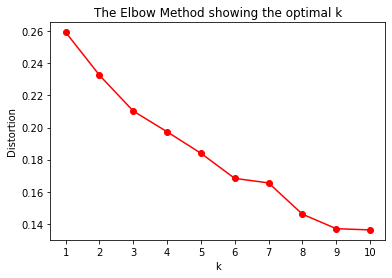

In [23]:
############ ELBOW GRAPH ################# 
#to see which K is the best possible k 
#need these extra modules to perform this graph:

from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt 
%matplotlib inline

#for loop to test each iteration of k from 1-10
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=3)
    kmeanModel.fit(cluster_group)
    distortions.append(sum(np.min(cdist(cluster_group, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / cluster_group.shape[0])
    

plt.plot(K, distortions, marker='o', linestyle='-', color='r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.xticks(K)
plt.show()    



The elbow looks to be at 'k = 3' so that 'n_cluster = 3' would be the optimal number of clusters

In [24]:
#Creating the kmeans clustering algorithm and fitting it to the dataframe
kclusters = 3

kmeans= KMeans(init = "k-means++", n_clusters = kclusters, n_init = 12,random_state=3)

kmeans.fit(cluster_group)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=3, tol=0.0001, verbose=0)

#### Joining the two dataframes and adding the cluster labels


In [25]:
#Putting the cluster labels into a variable and inserting it into the sorted venues dataframe
labels = kmeans.labels_

toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


#Combining the two dataframes together

tor_merged = toronto_bor #Setting the borough dataframe to a new variable

#Joining the two, dropping the Postal Code column and resetting the index
tor_merged = tor_merged.join(toronto_venues_sorted.set_index('Neighborhoods'), on = 'Neighborhood')
tor_merged.drop('Postal Code',axis=1,inplace=True)
tor_merged.reset_index(drop=True)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,East Toronto,The Beaches,43.676357,-79.293031,1,Neighborhood,Health Food Store,Pub,Trail,Electronics Store
1,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Restaurant
2,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1,Park,Fast Food Restaurant,Pet Store,Pub,Brewery
3,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,American Restaurant,Bakery,Brewery
4,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Swim School,Bus Line,Yoga Studio,Diner
5,Central Toronto,Davisville North,43.712751,-79.390197,1,Gym,Hotel,Breakfast Spot,Food & Drink Shop,Sandwich Place
6,Central Toronto,North Toronto West,43.715383,-79.405678,1,Clothing Store,Coffee Shop,Furniture / Home Store,Café,Bagel Shop
7,Central Toronto,Davisville,43.704324,-79.388790,1,Sandwich Place,Dessert Shop,Sushi Restaurant,Pizza Place,Gym
8,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0,Park,Summer Camp,Yoga Studio,Dessert Shop,Falafel Restaurant
9,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,1,Coffee Shop,Pub,Bagel Shop,Sports Bar,Vietnamese Restaurant


#### Creating the Cluster Map

In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neigh, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], tor_merged['Neighborhood'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(neigh) + ','+' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster 1:
    This cluster seems to be known for it's physical and outdoor activities

In [27]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
44,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Diner
48,"Moore Park, Summerhill East",Park,Summer Camp,Yoga Studio,Dessert Shop,Falafel Restaurant
50,Rosedale,Park,Playground,Trail,Yoga Studio,Department Store


## Cluster 2:
    This cluster has the most neighborhoods and it seems what they all have in common is the food services.

In [28]:
tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
37,The Beaches,Neighborhood,Health Food Store,Pub,Trail,Electronics Store
41,"The Danforth West, Riverdale",Greek Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Restaurant
42,"India Bazaar, The Beaches West",Park,Fast Food Restaurant,Pet Store,Pub,Brewery
43,Studio District,Café,Coffee Shop,American Restaurant,Bakery,Brewery
45,Davisville North,Gym,Hotel,Breakfast Spot,Food & Drink Shop,Sandwich Place
46,North Toronto West,Clothing Store,Coffee Shop,Furniture / Home Store,Café,Bagel Shop
47,Davisville,Sandwich Place,Dessert Shop,Sushi Restaurant,Pizza Place,Gym
49,"Summerhill West, Rathnelly, South Hill, Forest...",Coffee Shop,Pub,Bagel Shop,Sports Bar,Vietnamese Restaurant
51,"St. James Town, Cabbagetown",Coffee Shop,Restaurant,Pizza Place,Café,Pub
52,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Pub


## Cluster 3
    This cluster doesn't give us much information besides that most of the common venues are food services.

In [29]:
tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
63,Roselawn,Garden,Yoga Studio,Dessert Shop,Farmers Market,Falafel Restaurant
